In [ ]:
!pip install pandas==1.5.3
!pip install sentence-transformers accelerate -U
!pip install transformers[torch] -U
# !pip install accelerate -U --force-reinstall

import accelerate
import transformers
print("Accelerate version:", accelerate.__version__)
print("Transformers version:", transformers.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd

file_folder = '/content/drive/My Drive/224_project/'
# Specify Google Drive folder ID and file names
folder_id = "1ofzm63QbNlrcRlh5KbD0-3WDuiUYGJYt"
train_file_name = 'sustainability_business_activities_training.csv'
test_file_name = 'sustainability_business_activities_test.csv'
EPA_file_name = 'EPA_EmissionData.csv'
movies_file_name = 'movies.csv'

# Define the fields to potentially introduce errors
fields = ['Business Activity Description', 'Business Activity Vendor', 'Business Activity Comment']
# num_min_error_columns = 3
# num_max_error_columns = 3
# row_error_rate = 0.5    # number between 0 and 1.0, 1.0 means every row has error, 0 means no row has error, 0.5 means half the rows have error
# word_replace_error_rate = 0.3     # number between 0 and 1.0, 1.0 means every word is replaced in a given column, 0 means no word replaced, 0.5 means half the words replaced
naics_title_column_name = '2017 NAICS Title'
activity_cost_column_name = 'Business Activity Cost USD'
epa_emission_factor_column_name = 'Supply Chain Emission Factors without Margins'
separator_string = " [SEP] "
error_column_append_text = " Error"
combined_text_column_name = 'combined_text'
encoded_label_column_name = 'encoded_labels'

demo_mode = True
debug_print = False


In [ ]:

def read_df_from_file(file_name):
  file_id = find_file_id_by_name(file_name)
  data = drive.CreateFile({'id': file_id})
  data.GetContentFile(file_name)
  df = pd.read_csv(file_name)
  print(f"{len(df)} of rows in {file_name} csv")
  return df

def find_file_id_by_name(file_name):
    """Search for a file by name in the specified Google Drive folder."""
    query = f"'{folder_id}' in parents and trashed=false and title='{file_name}'"
    file_list = drive.ListFile({'q': query}).GetList()
    return file_list[0]['id'] if file_list else None

factor_df = read_df_from_file(EPA_file_name)
movies_df = read_df_from_file(movies_file_name)
activity_df = read_df_from_file(train_file_name)
test_df = read_df_from_file(test_file_name)


1016 of rows in EPA_EmissionData.csv csv
58098 of rows in movies.csv csv
13744 of rows in sustainability_business_activities_training.csv csv
2756 of rows in sustainability_business_activities_test.csv csv


In [ ]:
label_dict = {value: idx for idx, value in enumerate(activity_df[naics_title_column_name].unique())}
activity_df[encoded_label_column_name] = activity_df[naics_title_column_name].map(label_dict)

In [ ]:
import pandas as pd
import re

def extract_words_from_movies(df, column_name):
    words_list = []

    # Regular expression to match only alphabetic characters
    alpha_pattern = re.compile('[^a-zA-Z\s]')

    for movie in df[column_name]:
        # Remove punctuation and numeric characters
        clean_movie = alpha_pattern.sub('', movie)

        # Split into words and filter based on length
        words = [word for word in clean_movie.split() if len(word) >= 4]

        words_list.extend(words)

    unique_words_set = set(words_list)
    unique_words_list = list(unique_words_set)
    return unique_words_list

noise_words_list = extract_words_from_movies(movies_df, 'title')

In [ ]:
import pandas as pd
import numpy as np
import random

# Helper functions
def introduce_minor_errors(text):
    """Introduce minor spelling mistakes in the text."""
    errors_introduced = 0
    max_errors = random.randint(2, 3)  # Decide to introduce 2 or 3 minor errors

    while errors_introduced < max_errors and len(text) > 4:  # Ensure text is long enough to alter
        error_type = random.choice(['substitute', 'omit', 'swap'])
        error_index = random.randint(1, len(text) - 2)  # Avoid beginning and end of the text for simplicity

        if error_type == 'substitute':
            # Substitute a character with a nearby character (mimicking common typing errors)
            substitutions = {'a': 's', 's': 'a', 'd': 'f', 'i': 'o', 'o': 'p', 'e': 'r', 'r': 't'}
            if text[error_index] in substitutions:
                text = text[:error_index] + substitutions[text[error_index]] + text[error_index + 1:]
                errors_introduced += 1

        elif error_type == 'omit':
            # Omit a character
            text = text[:error_index] + text[error_index + 1:]
            errors_introduced += 1

        elif error_type == 'swap':
            # Swap two adjacent characters
            if error_index < len(text) - 1:  # Ensure there's a character to swap with
                text = text[:error_index] + text[error_index + 1] + text[error_index] + text[error_index + 2:]
                errors_introduced += 1
    return text
'''
def introduce_major_errors(text):
    """Replace or scramble parts of the text to introduce major errors."""
    # Randomly choose between scrambling or inserting irrelevant text
    if random.random() < 0.5:
        return ''.join(random.sample(text, len(text)))
    else:
        return "Irrelevant text " + ''.join(random.sample(text, len(text)))
    return text
'''
import random

def introduce_errors_with_replacement(text, noise_words_list):
    words = text.split()
    num_words_to_replace = max(1, int(len(words) * word_replace_error_rate))  # Ensure at least one word is replaced

    # Generate indices for the words to replace
    indices_to_replace = random.sample(range(len(words)), num_words_to_replace)

    for i in indices_to_replace:
        # Ensure the replacement word is not the same as the original word
        replacement_word = random.choice(noise_words_list)
        while replacement_word == words[i]:
            replacement_word = random.choice(noise_words_list)
        words[i] = replacement_word

    # Join the words back into a single string
    modified_text = ' '.join(words)
    return modified_text

# Example usage:
# unique_words_list = ['unique', 'words', 'list', 'from', 'movies']
# text = "This is an example sentence to demonstrate the function."
# modified_text = introduce_errors_with_replacement(text, unique_words_list)
# print(modified_text)

# Function to randomly apply either minor or major errors to a text
def apply_random_error(text):
    if random.random() <= row_error_rate:  # 15% chance to introduce an error
      return introduce_errors_with_replacement(text, noise_words_list)   # only major errors
    return text


def apply_errors_with_limit(row, fields):
    """
    Randomly apply errors to a limited number of fields in a row.

    Parameters:
    - row: The DataFrame row to apply errors to.
    - fields: A list of field names to potentially apply errors to.
    - max_errors: Maximum number of fields to apply errors to.
    """
    # Randomly decide how many fields to apply errors to (0 to max_errors)
    errors_to_apply = random.randint(num_min_error_columns, num_max_error_columns)

    # Randomly select the fields where errors will be applied
    if len(fields) <= num_min_error_columns:
      fields_with_errors = fields
    else:
      fields_with_errors = random.sample(fields, errors_to_apply)

    # Apply errors to the selected fields
    for field in fields:
        if field in fields_with_errors:
            row[field + error_column_append_text] = apply_random_error(row[field])
        else:
            row[field + error_column_append_text] = row[field]

    return row

def combine_text_fields(row, fields):
    """
    Combine multiple text fields into a single combined text string.

    Parameters:
    - row: A DataFrame row containing the text fields.
    - fields: A list of field names to be combined.

    Returns:
    - combined_text: A string containing the combined text from the specified fields.
    """
    combined_parts = []
    for field in fields:
        # Assuming the 'Error' versions of fields are already in the DataFrame
        error_field_name = f"{field}{error_column_append_text}"
        if error_field_name in row:
            field_label = field.replace(" ", "_")  # Replace spaces with underscores for label
            combined_parts.append(f"{field_label}: {row[error_field_name]}")
    combined_text = separator_string.join(combined_parts)
    return combined_text

In [ ]:
# Example usage:
#text = "This is an example sentence to demonstrate the function."
#modified_text = introduce_errors_with_replacement(text, noise_words_list)
#print(modified_text)

In [ ]:
from datetime import datetime

def add_noise(activity_df):
  current_date = datetime.now()
  # Format month as 3-letter abbreviation and day as a number
  formatted_date = current_date.strftime('%b%d')

  # Apply errors to 2 or fewer fields for each row
  error_activity_df = activity_df.apply(lambda row: apply_errors_with_limit(row, fields), axis=1)
  # Apply the function to each row of the DataFrame to create the 'combined_text' column
  error_activity_df[combined_text_column_name] = error_activity_df.apply(lambda row: combine_text_fields(row, fields), axis=1)
  # Now, 'combined_text' contains the concatenated texts with either minor or major errors introduced
  temp_train_file_name = f'train_{formatted_date}.csv'
  error_activity_df.to_csv(temp_train_file_name)

  # Apply errors to 2 or fewer fields for each row
  error_test_df = test_df.apply(lambda row: apply_errors_with_limit(row, fields), axis=1)
  # Combine the possibly altered text fields into a new 'combined_text' column
  error_test_df[combined_text_column_name] = error_test_df.apply(lambda row: combine_text_fields(row, fields), axis=1)
  temp_test_file_name = f'test_{formatted_date}.csv'
  error_test_df.to_csv(temp_test_file_name)
  return error_activity_df, error_test_df

In [ ]:
import numpy as np
import random
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.feature_extraction.text import TfidfVectorizer

def train_test_model(error_activity_df, test_df):

  # Split data into features and labels
  # activity_df['combined_text'] = activity_df['Business Activity Description'] + " " + activity_df['Vendor'] + " " + activity_df['Comment']
  X = error_activity_df[combined_text_column_name]  # Feature
  y = error_activity_df[encoded_label_column_name]  # Assuming 'label' is already encoded as numeric labels

  # Splitting dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  # Initialize and fit the TF-IDF vectorizer on training data
  tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
  X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)


  # Define the parameter grid
  param_dist = {
      "n_estimators": [600, 800, 1000, 1200, 1400],  # Increased range based on previous best
      "max_depth": [50, 60, 80],  # Explore deeper trees and some constraints
      "min_samples_split": [8, 10, 12, 15, 18],  # Narrowing down around the best found value
      "min_samples_leaf": [1, 2, 3],  # Exploring around the best found value
      "max_features": ['sqrt', 'log2', None]  # Adding exploration around 'log2'
  }

  if demo_mode:
    if debug_print is True:
      print("In the demo mode, not running the random_search....")
  else:
    # Initialize the RandomForest model
    clf = RandomForestClassifier(random_state=42)

    # Initialize RandomizedSearchCV
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, cv=5, scoring='accuracy')

    # Fit the model
    random_search.fit(X_train_tfidf, y_train)

    print("Best parameters:", random_search.best_params_)
    # Best parameters: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 60}
    # Best parameters: {'n_estimators': 1200, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 60}
    # Best parameters: {'n_estimators': 1000, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 80}

  # Previously selected best parameter sets
  selected_params = [
      {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 60},
      {'n_estimators': 1200, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 60},
      {'n_estimators': 1000, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 80}
  ]

  # Choose a parameter set (e.g., the first one)
  chosen_params = selected_params[0]
  if demo_mode:
    if debug_print is True:
      print(f"In demo mode, moving forward with params: {chosen_params}")
  else:
    chosen_params = random_search.best_params_
  # Initialize the RandomForest model with the chosen parameters
  best_clf = RandomForestClassifier(**chosen_params, random_state=42)
  # Fit the model
  best_clf.fit(X_train_tfidf, y_train)
  # Transform the test data using the same TF-IDF vectorizer
  X_test_tfidf = tfidf_vectorizer.transform(X_test)
  # Make predictions on the test data
  y_pred = best_clf.predict(X_test_tfidf)

  # Convert y_test to a DataFrame for easier manipulation
  y_test_df = pd.DataFrame(y_test)
  y_test_df.reset_index(drop=True, inplace=True)

  # Convert y_pred to a DataFrame
  y_pred_df = pd.DataFrame(y_pred, columns=['Predicted'])

  # Concatenate the true labels, predicted labels, and the original text features for comparison
  results_df = pd.concat([y_test_df, y_pred_df, X_test.reset_index(drop=True)], axis=1)
  results_df.columns = ['True_Label', 'Predicted_Label', 'Features']

  # Filter to find where predictions were incorrect
  incorrect_predictions = results_df[results_df['True_Label'] != results_df['Predicted_Label']]

  '''
  # Add a prefix to 'Features' to indicate these are from true labels
  incorrect_predictions['Features_True_Label'] = 'True label: ' + incorrect_predictions['Features']
  # Since 'Features' based on 'Predicted_Label' doesn't exist directly, we replicate 'Features' column
  # and add a prefix to indicate these are hypothetically what you'd expect for predicted labels
  # Note: This does not fetch different 'Features' text for 'Predicted_Label'; it's illustrative
  incorrect_predictions['Features_Predicted_Label'] = 'Predicted label: ' + incorrect_predictions['Features']
  '''

  # Set option to display full text without truncation for investigation
  if debug_print is True:
    pd.set_option('display.max_colwidth', None)
    print(f"Rows {len(incorrect_predictions)} in Incorrect Predictions: ")
    print(incorrect_predictions[['True_Label', 'Predicted_Label', 'Features']])
    # Reset display option
    pd.reset_option('display.max_colwidth')

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


    # Assuming clf is your trained RandomForestClassifier and tfidf_vectorizer is your fitted TF-IDF vectorizer
  test_df[encoded_label_column_name] = test_df[naics_title_column_name].apply(lambda x: label_dict.get(x, -1))  # Unseen labels get -1

  X_test_new = test_df[combined_text_column_name]  # Feature
  y_test_new = test_df[encoded_label_column_name]  # Replace 'label' with the actual column name for labels in your test data

  # Transform the test data using the already fitted TF-IDF vectorizer
  X_test_new_tfidf = tfidf_vectorizer.transform(X_test_new)

  # Make predictions on the new test data
  y_pred_new = best_clf.predict(X_test_new_tfidf)

  # Evaluate the model on the new test data
  if debug_print is True:
    print("New Test Data - Classification Report:\n", classification_report(y_test_new, y_pred_new))
    print("New Test Data - Accuracy:", accuracy_score(y_test_new, y_pred_new))
  return accuracy_score(y_test_new, y_pred_new)*100, accuracy_score(y_test, y_pred)*100


In [ ]:
import matplotlib.pyplot as plt
import torch


# Check if a GPU is available and set it as the device, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming these lists are used to collect the data.
error_rates = []
train_accuracies = []
test_accuracies = []
num_min_error_columns = 3
num_max_error_columns = 3

for i in range(12, 41):
    row_error_rate = i / 40
    word_replace_error_rate = row_error_rate
    train_df_with_error, test_df_with_error = add_noise(activity_df)
    train_accuracy, test_accuracy = train_test_model(train_df_with_error, test_df_with_error)
    print(f"ErrRate: {row_error_rate}, TrainAccuracy: {train_accuracy:.3f}%, TestAccuracy:{test_accuracy:.3f}%")
    error_rates.append(row_error_rate)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

ErrRate: 0.3, TrainAccuracy: 100.000%, TestAccuracy:100.000%
ErrRate: 0.325, TrainAccuracy: 100.000%, TestAccuracy:100.000%
ErrRate: 0.35, TrainAccuracy: 99.964%, TestAccuracy:100.000%
ErrRate: 0.375, TrainAccuracy: 100.000%, TestAccuracy:100.000%
ErrRate: 0.4, TrainAccuracy: 99.964%, TestAccuracy:99.964%
ErrRate: 0.425, TrainAccuracy: 100.000%, TestAccuracy:99.854%
ErrRate: 0.45, TrainAccuracy: 99.964%, TestAccuracy:99.964%
ErrRate: 0.475, TrainAccuracy: 100.000%, TestAccuracy:100.000%
ErrRate: 0.5, TrainAccuracy: 99.891%, TestAccuracy:99.782%
ErrRate: 0.525, TrainAccuracy: 99.710%, TestAccuracy:99.636%
ErrRate: 0.55, TrainAccuracy: 99.782%, TestAccuracy:99.818%
ErrRate: 0.575, TrainAccuracy: 99.746%, TestAccuracy:99.782%
ErrRate: 0.6, TrainAccuracy: 99.456%, TestAccuracy:99.418%
ErrRate: 0.625, TrainAccuracy: 99.311%, TestAccuracy:99.527%
ErrRate: 0.65, TrainAccuracy: 99.311%, TestAccuracy:99.382%
ErrRate: 0.675, TrainAccuracy: 98.440%, TestAccuracy:98.436%
ErrRate: 0.7, TrainAccurac

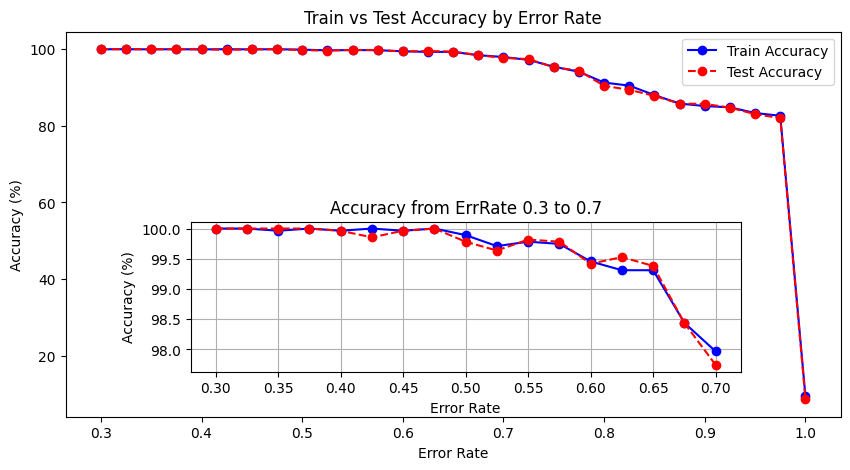

Uploaded/Updated file with ID: 10TWg16hAEIfuI4gcGK3Rz5I3zezVDJy2


In [ ]:
import matplotlib.pyplot as plt

err_rate_plot_fname = "accuracy_vs_error_rate_" + datetime.now().strftime("%Y%m%d") + ".png"
# Plot the main figure
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the line for training accuracy
ax1.plot(error_rates, train_accuracies, 'o-', color='blue', label='Train Accuracy')

# Plot the line for testing accuracy
ax1.plot(error_rates, test_accuracies, 'o--', color='red', label='Test Accuracy')

# Label the main figure
ax1.set_xlabel('Error Rate')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Train vs Test Accuracy by Error Rate')
ax1.legend(loc='upper right')
# ax1.grid(True)

# Define the indices for the error rates of 0.3 to 0.7
start_index = error_rates.index(0.3)
end_index = error_rates.index(0.7) + 1  # Add 1 because slice end index is exclusive

# Add an inset to the main plot (the axes' rectangle [left, bottom, width, height] are in figure coordinates)
ax2 = fig.add_axes([0.25, 0.2, 0.55, 0.3])

# Plot the zoomed-in range on the inset axes
ax2.plot(error_rates[start_index:end_index], train_accuracies[start_index:end_index], 'o-', color='blue')
ax2.plot(error_rates[start_index:end_index], test_accuracies[start_index:end_index], 'o--', color='red')

# Inset figure labels and titles
ax2.set_title('Accuracy from ErrRate 0.3 to 0.7')
ax2.set_xlabel('Error Rate')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)
plt.savefig(err_rate_plot_fname)
# Show the plot
plt.show()

# Check if the file already exists in Drive
image_file_id = find_file_id_by_name(err_rate_plot_fname)
# Depending on whether the file exists or not, create new or update existing
if image_file_id:
    # File exists, so update it
    image_file = drive.CreateFile({'id': image_file_id})
    image_file.SetContentFile(err_rate_plot_fname)
    image_file.Upload()  # Upload the file.
else:
    # File does not exist, so create a new file in the specified folder
    image_file = drive.CreateFile({
        'title': err_rate_plot_fname,
        'parents': [{'id': folder_id}]  # Specify the parent folder
    })
    image_file.SetContentFile(err_rate_plot_fname)
    image_file.Upload()

print(f'Uploaded/Updated file with ID: {image_file["id"]}')

In [ ]:
num_min_error_columns = 3
num_max_error_columns = 3
word_replace_error_rate = row_error_rate = 0.5

train_df_with_error, test_df_with_error = add_noise(activity_df)

X = train_df_with_error[combined_text_column_name]  # Feature
y = train_df_with_error[encoded_label_column_name]  # Assuming 'label' is already encoded as numeric labels

In [ ]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from transformers import logging
import os
import matplotlib.pyplot as plt
import time

logging.set_verbosity_error()

# Check if a GPU is available and set it as the device, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Assume X and y are your dataset features and labels respectively

# Tokenize and prepare data for BERT
def encode_data(tokenizer, texts, max_length=512):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Evaluation function modified to include device
def evaluate(model, dataloader, device):
    model.eval()
    predictions , true_labels = [], []

    for batch in dataloader:
        # Move batch to device
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    return predictions, true_labels

# Splitting dataset into training and testing sets
# Ensure X and y are defined before this line
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
max_length = 128  # Adjust based on your dataset
X_train_ids, X_train_masks = encode_data(tokenizer, X_train, max_length=max_length)
X_test_ids, X_test_masks = encode_data(tokenizer, X_test, max_length=max_length)

y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_ids, X_train_masks, y_train)
test_dataset = TensorDataset(X_test_ids, X_test_masks, y_test)

# Create DataLoaders
batch_size = 64  # Adjust based on your system capabilities
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(np.unique(y)))  # Adjust the number of unique labels accordingly
model.to(device)  # Move model to the selected device

# Optimizer & scheduler setup
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 50  # Adjust based on your dataset
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
loss_values = []  # Initialize an empty list to store the loss values
start_time = time.time()  # Record the start time
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Move batch to device
        # print(f"Step: {step + 1}")
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")
    loss_values.append(avg_train_loss)
end_time = time.time()  # Record the end time
total_training_time = end_time - start_time  # Calculate total training time
print(f"Total training time: {total_training_time//3600} hours, {(total_training_time%3600)//60} minutes, {total_training_time%60} seconds")



In [ ]:
# Function to check for a folder inside a specified parent folder and create it if it doesn't exist
def create_folder_in_parent(folder_name, parent_folder_id):
    # Auto-iterate through all files that match the query
    file_list = drive.ListFile({'q': f"'{parent_folder_id}' in parents and trashed=false"}).GetList()

    # Check if folder exists
    for file in file_list:
        if file['title'] == folder_name and file['mimeType'] == 'application/vnd.google-apps.folder':
            print(f"Folder '{folder_name}' already exists inside the specified parent folder.")
            return file['id']

    # If folder does not exist, create it
    folder_metadata = {
        'title': folder_name,
        # The mimetype defines this new file as a folder, so don't change this.
        'mimeType': 'application/vnd.google-apps.folder',
        'parents': [{'id': parent_folder_id}]
    }
    folder = drive.CreateFile(folder_metadata)
    folder.Upload()
    print(f"Folder '{folder_name}' created inside the specified parent folder.")
    return folder['id']

# folder_name = '/plots/bert/'

# Call the function to create a new folder inside the existing folder
plots_folder_id = create_folder_in_parent("plots", folder_id)
bert_folder_id = create_folder_in_parent("bert", plots_folder_id)
print(f"The new folder ID is: {bert_folder_id}")
bert_model_folder_id = create_folder_in_parent("best_model", folder_id)


In [ ]:
current_date = datetime.now().strftime("%Y%m%d")
plot_name = f"tloss_{current_date}.png"
# Save the training loss plot
plot_dir = "/content/drive/My Drive/224_project/plots/bert/"
plot_path = plot_dir + plot_name
plt.figure(figsize=(10, 8))
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(plot_name)  # Saving the plot to the specified path
plt.close()  # Close the plot to free up memory

# Check if the file already exists in Drive
image_file_id = find_file_id_by_name(plot_path)
# Depending on whether the file exists or not, create new or update existing
if image_file_id:
    # File exists, so update it
    image_file = drive.CreateFile({'id': image_file_id})
    image_file.SetContentFile(plot_path)
    image_file.Upload()  # Upload the file.
else:
    # File does not exist, so create a new file
    image_file = drive.CreateFile({
        'title': plot_name,
        'parents': [{'id': bert_folder_id}]  # Specify the parent folder
    })
    image_file.SetContentFile(plot_name)
    image_file.Upload()


    #image_file = drive.CreateFile({'title': plot_path})
    #image_file.SetContentFile(plot_name)
    #image_file.Upload()

print(f'Uploaded/Updated file with ID: {image_file["id"]}')

# Get predictions for test data
predictions, true_labels = evaluate(model, test_dataloader, device)
y_pred = np.argmax(predictions, axis=1)

print("Classification Report:\n", classification_report(true_labels, y_pred))
print("Accuracy:", accuracy_score(true_labels, y_pred))

# Save the model
model_folder_id = create_folder_in_parent("best_model", folder_id)
date_folder_id = create_folder_in_parent(current_date, folder_id)

save_directory = "/content/drive/My Drive/224_project/best_model/"

# Append the current date in the format YYYYMMDD
save_directory = save_directory + current_date + "/"

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)